The radiation source ELBE (**E**lectron **L**inac for beams with high **B**rilliance and low **E**mittance) at the Helmholtz Centre Dresden Rossendorf (HZDR) can produce several kinds of secondary radiations. THz radiation is one of them and can be used with a typical pulse frequency of 100 kHz as a stimulation source for elementary low-energy degrees of freedom in matter. It was used in the \"Phase-resolved Higgs response in superconducting cuprates\" publication (DOI: [10.1038/s41467-020-15613-1](https://doi.org/10.1038/s41467-020-15613-1)). The raw data for this publication can be accessed on RODARE (DOI: [10.14278/rodare.1289](https://doi.org/10.14278/rodare.1289)) and will be used to reproduce the figures from the publication

This Jupyter notebook enables the user to handle the raw data from an TELBE THz experiment. To sample the whole THz wave the laser path length is modified by moving specific mirrors. The raw data contains for each mirror position a binary file storing the signal spectra and a folder with gray scaled tiff files storing the jitter timing.

The notebook contains 2 parts. For new data start with **1. Sorting and binning the raw data**. If you have it done already in a previous session continue with section **2. Plotting results** in the middle of this notebook.

## 1. Sorting and binning of raw data

### 1.1. Import Packages

Common libraries like numpy and scipy are used to handle the data matrices and to filter the signal data. Multiprocessing is used to use multiple cores for the parallelized parts and the number of cores can be individual adjusted. Matplotlib is used to present the results visually.

In [1]:
%pip install numpy
%pip install pillow
%pip install scipy
%pip install matplotlib
import numpy as np
from PIL import Image
from scipy.signal import butter, lfilter
import os, sys, time, requests, re, json, fnmatch, shutil
from zipfile import BadZipFile, ZipFile
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from multiprocessing import Pool
from functools import partial
from urllib import request
from urllib.parse import urlparse

### 1.2. Load class containing functions to sort and bin the raw data 


In [2]:
class sorting_binning:
    """Class to manage the sorting and binning process for TELBE raw data."""
    
    def __init__(self, folder_in, params):
        if not os.path.isdir(folder_in):
            print(f'Folder {folder_in} does not exist!')
            sys.exit(1)

        if folder_in[-1] == '/':
            folder_in = folder_in[:-1]

        """Set variables/constants"""
        self.rep = params['rep'] # repetition rate of TELBE in Hz
        self.t_exp = params['t_exp'] # time os single step measurement
        self.N_sample = params['N_sample'] # number of points measured by ADC for single event - it should be even 
        self.offset = params['offset'] # offset between CCD and ADC
        self.pixel_to_ps = params['pixel_to_ps'] # conversion from pixel to ps
        self.Stage_zero = params['Stage_zero'] # position in mm of zero time
        self.mm_to_ps = 1/299792458*2*10**9
        self.searchstring = "[0-9]{2}.[0-9]{2}.[0-9]{4}_[0-9]{4}_[0-9]{2}"
        self.set_savesort()
        self.set_cores()
        self.set_res(0.02)  # time resolution for binned file

        self.folder_in = folder_in
        top_folder, folder_name = os.path.split(self.folder_in)

        date_str = re.search(self.searchstring, folder_name)[0]
        date = datetime.strptime(date_str, '%d.%m.%Y_%H%M_%S')
        folder = f'{date:%Y-%B_datasorting}'
        datasorting_folder = os.path.join(str(date.year), folder)

        folder = f'{date:%Y-%m-%d}'
        self.sorted_folder = os.path.join(datasorting_folder, folder)
        self.binned_folder = os.path.join(self.sorted_folder, 'binned')
        os.makedirs(self.binned_folder, exist_ok=True)

        self.file_out_sorted = os.path.join(self.sorted_folder, folder_name + '_sorted.dat')
        self.file_out_binned = os.path.join(self.binned_folder, folder_name + '_sorted_binned.dat')


    def set_savesort(self, savesort=False):
        self.savesort = savesort
    
    def set_cores(self, cores=1):
        self.cores = cores

    def set_recalc(self, recalc=False):
        self.recalc = recalc
    
    def set_res(self, res=0.02):
        self.res = res
        
    def _jitter(self, SP, BG, graph):
        """Correct the timing of each electron pulse."""
        low_cut=0.00001
        high_cut=0.04
        b, a = butter(3, [low_cut, high_cut], btype='band')
        bg=np.genfromtxt(BG,max_rows=1)
        arrival_time=np.array([])
        images = os.listdir(SP)
        images.sort()
        for i in images:
            im = Image.open(os.path.join(SP,i))
            SDEOS = np.array(im, dtype=np.uint16)
            if SDEOS[0,0] > 2**15 - 1:
                SDEOS = SDEOS - 2**15
            arrival_time = np.concatenate([arrival_time,[np.argmax(lfilter(b, a, SDEOS[j,:]-bg))\
                                                         for j in range(0, SDEOS.shape[0])]])
        if graph:
            filtered = lfilter(b, a, SDEOS[1,:]-bg)
            x_fil = range(len(filtered))
            raw = SDEOS[1,:]-bg
            x_raw = range(len(raw))
            jitter_data = np.array([x_raw,raw,x_fil,filtered])
            with open('tmp.txt','w') as jitter_dump:
                np.savetxt(jitter_dump, jitter_data)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(x_raw,raw,label="raw data")
            ax.plot(x_fil,filtered,label="butter fit")
            fig.savefig('jitter'+os.path.basename(SP)+'.png')
            print('"Check "jitter'+os.path.basename(SP)+'.png" if fit is good.')
        return arrival_time  


    def _signal(self, ADC):
        """Integrate the Signal of each electron pulse."""
        N_shots=int(self.rep/self.t_exp) # pulses of TELBE per single step
        ADC_Width=int(self.N_sample/2) # half of the trace is for signal, second half - for background
        t1=np.fromfile(ADC,dtype='>f')
        Signal=np.zeros(N_shots)
        for i in range(0,N_shots):
            Signal[i]=np.sum(t1[(self.N_sample*i):(self.N_sample*i+ADC_Width)])-\
                np.sum(t1[(self.N_sample*i+ADC_Width):(self.N_sample*i+self.N_sample)])
        return Signal    


    def _bin_mean(self, data, digitized, bin_n):
        """Calculate the mean of each bin."""
        data_bin = data[digitized == bin_n]
        if len(data_bin) == 0:
            return np.nan
        else:
            return np.mean(data_bin)

    def binning(self):
        """Binning of the sorted data."""
        self.start = time.time()
        print(f'Binned file:\t{self.file_out_binned}')
        if os.path.isfile(self.file_out_binned) and not self.recalc:
            print('Load from file')
            self.binned_data = np.loadtxt(self.file_out_binned)
            print(f"Time loading from file: {time.time()-self.start:.2f} s")
        else:
            print('Start binning')
            sorted_min = int(np.floor(min(self.sorted_data[:,0])*self.pixel_to_ps/self.res))
            sorted_max = int(np.ceil(max(self.sorted_data[:,0])*self.pixel_to_ps/self.res))
            num = int(np.floor(np.abs(sorted_max - sorted_min)))
            space_bin = np.linspace(sorted_min, sorted_min + num, num=num + 1)*self.res
            digitized=np.digitize(self.sorted_data[:,0]*self.pixel_to_ps,space_bin)
            print(f"Time elapsed after preparing binning: {time.time()-self.start:.2f} s")
            with Pool(self.cores) as processPool:
                mean_bin = processPool.map(partial(self._bin_mean, self.sorted_data[:,1], digitized),\
                                           range(0, len(space_bin)))
            self.binned_data = np.vstack((space_bin, mean_bin)).T
            np.savetxt(self.file_out_binned, self.binned_data, fmt='%0.{}f %0.8f'.format(int(np.ceil(np.log10(1/self.res)))))
            print(f"Time elapsed after multiprocessing binning: {time.time()-self.start:.2f} s")
            print('Binning done')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.binned_data[:,0], self.binned_data[:,1])
        ax.set_xlabel(r'time / ps')
        ax.set_ylabel(r'signal / a.u.')
        #fig.savefig('binning.png')


    def _sorting_one_position(self, subfolder, subfiles, BG, first_folder):
        """Calculate the jitter and signal data for each mirror position."""
        stage_pos = re.findall('_([0-9.]*)mm', subfolder)[-1]
        EOS=fnmatch.filter(subfiles, '*'+'Experiment'+'*'+stage_pos+'*')[0]
        jitter_data = (self._jitter(subfolder, BG, first_folder == subfolder)\
                       +(float(stage_pos)-self.Stage_zero)*self.mm_to_ps/self.pixel_to_ps).astype(int)
        signal_data = np.roll(self._signal(EOS),self.offset)
        if jitter_data.shape[0] != signal_data.shape[0]:
            print(f"Shape of jitter data ({jitter_data.shape}) and signal data ({signal_data.shape}) is not consistent.\
                  Adjust parameter 'rep'")
        return np.vstack((jitter_data, signal_data)).T
    
        
    def sorting(self, position=None):
        """Sort all data points."""
        self.position = position
        self.start = time.time()
        print(f'Data folder: {self.folder_in}')
        if self.savesort:
            print(f'Sorted file:\t{self.file_out_sorted}')
        else:
            print('Sorted file is not stored')

        if os.path.isfile(self.file_out_sorted) and position is None and not self.recalc:
            print('Load from file')
            self.sorted_data = np.loadtxt(self.file_out_sorted)
            print(f"Time elapsed after loading sorted file: {time.time()-self.start:.2f} s")
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(self.sorted_data[:,0], self.sorted_data[:,1], s=1)
            ax.set_xlabel(r'pixel')
            ax.set_ylabel(r'signal / a.u.')
            ax.set_title(r'Sorted data');
            print('Loading done')
        else:
            print('Start sorting')
            subfolders = [f.path for f in os.scandir(self.folder_in) if f.is_dir()]
            subfolders.sort()
            if position is not None:
                self.position=fnmatch.filter(subfolders, '*'+position+'*mm*')
                if len(self.position) > 1:
                    print(f"found match for multiple positions. First one choosen:\n{self.position}")
                elif len(self.position) == 0:
                    print("No match found")
                    return 1
                else:
                    print(f"Sorting choosen for {self.position}")
                    subfolders = self.position
            subfiles = [f.path for f in os.scandir(self.folder_in) if f.is_file()]
            background = fnmatch.filter(subfiles, '*'+'_BG_'+'*')[0]
            if not background:
                print('Background file not found!')    #count_of_steps = len(subfolders)

            fig, axs = plt.subplots(ncols=2,figsize=(10, 4))
            print(f"Time elapsed for preparetion: {time.time()-self.start:.2f} s")
            with Pool(self.cores) as processPool:
                self.sorted_data = np.concatenate((processPool.map(
                    partial(self._sorting_one_position, subfiles=subfiles, BG=background,\
                            first_folder= subfolders[0]), subfolders)))
            with open('tmp.txt','r') as jitter_dump:
                self.jitter_data = np.loadtxt(jitter_dump)

            axs[0].plot(self.jitter_data[0],self.jitter_data[1],label="raw data")
            axs[0].plot(self.jitter_data[2],self.jitter_data[3],label="butter fit")
            axs[0].set_xlabel(r'time / pixel')
            axs[0].set_ylabel(r'signal / a.u.')
            axs[0].set_title(r'Determine jitter time');
            leg = axs[0].legend(loc='upper right', shadow=True)

            axs[1].scatter(self.sorted_data[:,0], self.sorted_data[:,1], s=1)
            axs[1].set_xlabel(r'pixel')
            axs[1].set_ylabel(r'signal / a.u.')
            axs[1].set_title(r'Sorted data');
            #fig.savefig('sorted.png')
            print(f"Time elapsed after multiprocessing sorting: {time.time()-self.start:.2f} s")
            if self.savesort and position is None:
                with open(self.file_out_sorted,'wb') as fff:
                    np.savetxt(fff, self.sorted_data) 
                print(f"Time elapsed after writing sorted file: {time.time()-self.start:.2f} s")
            print('Sorting done')

### 1.3. Select and download data set

1. Select a data set from the RODARE record (https://rodare.hzdr.de/record/1289). It contains all raw data from the Nature publication: https://doi.org/10.1038/s41467-020-15613-1. As an starting example choose one of the following file numbers, which where used to generate each individual figure from the publication:
   * Fig. 1(a): 053
   * Fig. 1(b): 038
   * Fig. 1(e): 033, 038, 045, 051, 053


2. copy link from the download button in an RODARE record (www.rodare.hzdr.de/record/1289)
3. save link as url variable

In [3]:
url = "https://rodare.hzdr.de/record/1289/files/038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02.zip?download=1"

parse_object = urlparse(url)
filename = parse_object.path.split("/")[-1]
if not os.path.isfile(filename):
    print("Downloading selected file.")
    request.urlretrieve(url, filename)
else:
    print(f"File {filename} exists already")
folder_in = os.path.splitext(filename)[0]
assert not os.path.isfile("raw_data"), "Remove or rename 'raw_data' file before rerun."
if not os.path.isdir(folder_in):
    try:
        print(f"Unpacking '{filename}' to '{folder_in}'.")
        with ZipFile(filename) as z:
            z.extractall(path="raw_data")
            # removing abs path
            path_list = [x[0] for x in os.walk('raw_data')]
            for path in path_list:
                if folder_in in path:
                    shutil.move(path, os.path.basename(path))
                    break
            shutil.rmtree('raw_data')
            print("Unpacking done.")
    except (FileNotFoundError, BadZipFile):
        print("Invalid zip file.")
        sys.exit(1)
else:
    print("File was already unpacked.")

Unpacking '038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02.zip' to '038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02'.
Unpacking done.


### 1.4. Set parameters and initialize class

The chooses parameters in params are set for the above mentioned RODARE record. A description for the parameters can be found in the class definition under section 1.2. Set *set_cores* to the number of availaible cores and set *set_savesort* to *False* if you don't want to save the intermediate sorted file (~350 MB, ~30 s to write on disk). With *set_res* you can change the size of the bins for the binning function (default is 0.02 ps). If you don't want to read from file set *set_recalc* to *True*.

In [4]:
params = {
    "rep": 100000,
    "t_exp": 1,
    "N_sample": 96,
    "offset": 0,
    "pixel_to_ps": 0.0115,
    "Stage_zero": 0
}
sortbin = sorting_binning(folder_in, params)
sortbin.set_cores(2)
sortbin.set_savesort(True)
#sortbin.set_res(0.02)
sortbin.set_recalc(True)

### 1.5. Run sorting raw data, choose one option

The main part of the sorting process is to correct the timing of each signal pulse. For each pulse the timing jitter is determined and assigned. 

Data folder: 038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02
Sorted file:	2018/2018-June_datasorting/2018-June_datasorting/038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02_sorted.dat
Start sorting
Time elapsed for preparetion: 0.05 s
"Check "jitter038_0p7THz_LSCO_2mmZnTe_31K_SD_101523Hz_51.10mm13.06.2018_0535_02.png" if fit is good.
Time elapsed after multiprocessing sorting: 323.34 s
Time elapsed after writing sorted file: 347.55 s
Sorting done


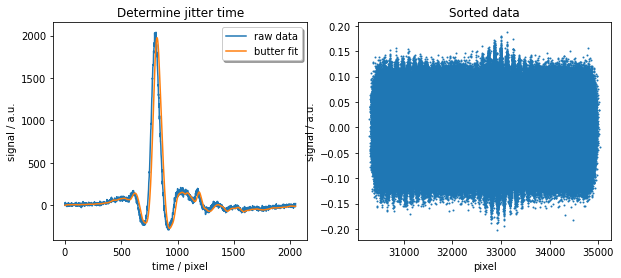

In [5]:
%matplotlib inline
"""Run single position by providing the mirror position in mm, written in the filename"""
#sortbin.sorting(position='51.1')

"""Run all position"""
sortbin.sorting()

### 1.6. Run binning data

After all data point have their correct time (x-value), a data reduction is done by the binning process. The mean value of all signal values in one bin is taken as the representative value for this bin. Now the wave is clearly visible.

Binned file:	2018/2018-June_datasorting/2018-June_datasorting/binned/038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02_sorted_binned.dat
Start binning
Time elapsed after preparing binning: 2.04 s
Time elapsed after multiprocessing binning: 47.49 s
Binning done


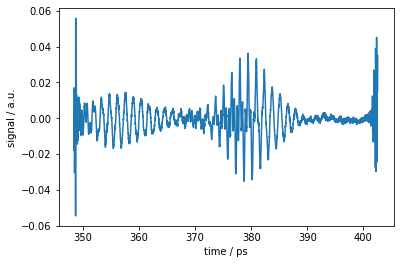

In [6]:
%matplotlib inline
sortbin.binning()

## 2. Plotting results

### 2.1 Load class containing function for plotting TELBE data

In [7]:
class plot_telbe:
    """Command Line Interface (CLI) class managing the user interaction."""

    def __init__(self, filelist):
        """Parser initialization."""

        self.filelist = []
        self.filenames = []
        for binned_file in filelist:
            if not os.path.isfile(binned_file):
                print(f'File {binned_file} does not exists!')
            else:
                self.filelist.append(binned_file)
                self.filenames.append(os.path.basename(binned_file))
        self.load_data()
                

    def cut_nan(self, data):
        """Cut off data points from both sides until all nan values are gone"""
        nan_array = np.where(np.isnan(data[:int(data.shape[0]/2),1:]))[0]
        if nan_array.shape[0] > 0: 
            lower_bound = nan_array.max() + 1
        else:
            lower_bound = 0
        nan_array = np.where(np.isnan(data[int(data.shape[0]/2):,1:]))[0]
        if nan_array.shape[0] > 0: 
            upper_bound = nan_array.min() - data[int(data.shape[0]/2):].shape[0]
        else:
            upper_bound = None
        return data[lower_bound:upper_bound]


    def _get_fft_data(self):
        """Generate fft data from all loops"""

        dt = np.round(self.data[10,0]-self.data[9,0],6)
        self.fft_data = np.empty([int(self.data.shape[0]/2)-1,self.data.shape[1]])
        for loop in range(self.data.shape[1]-1):
            x = self.data[:,0]
            yf = np.fft.fft(self.data[:,loop+1])
            freq = np.fft.fftfreq(x.shape[-1], d=dt)
            #### one side
            self.fft_data[:,loop+1] = np.abs(yf[0:int(len(x)/2-1)])
            self.fft_data[:,0] = np.abs(freq[0:int(len(x)/2-1)])


    def get_data_mean(self, data):
        """Get mean value over all loops"""
        if data.shape[1] == 2:
            return data

        mean = np.nanmean(data[:,1:], axis=1)
        return np.concatenate((data[:,0][:,None], mean[:,None]),axis=1)


    def load_data(self):
        """Load data of all files in the list"""
        data_list = []
        t_range = [[],[]]
        res = None
        for filepath in self.filelist[:]:
            data_list.append(self._load_file(filepath))
            if res is None:
                res = np.round(data_list[-1][10,0] - data_list[-1][9,0],5)
            else:
                res_new = np.round(data_list[-1][10,0] - data_list[-1][9,0],5)
                assert res == res_new , "binned files in list, don't have same time-resolution\
                and can't be plotted together"
            t_range[0].append(data_list[-1][0,0])
            t_range[1].append(data_list[-1][-1,0])
        
        data_array = np.zeros([int(np.round(np.abs(np.max(t_range[1]) - np.min(t_range[0]))/res) + 1),\
                               len(data_list) + 1])
        data_array[:] = np.nan
        pixel = np.linspace(int(np.min(t_range[0])/res), int(np.max(t_range[1])/res), data_array.shape[0]).astype(int)
        data_array[:,0] = list(pixel * res)
        pixel = list(pixel)
        for idx, data in enumerate(data_list):
            if np.round(np.sum(data[1:,0] - data[:-1,0] - res),3) != 0:
                print(f"{self.filelist[idx]} is not equally spaced or some values are missing")
            start = np.where(np.isclose(pixel, data[0,0] / res, atol=0.4))[0][0]
            data_array[start:start + data.shape[0],idx+1] = data[:,1]

        self.data = self.cut_nan(data_array)
        self._get_fft_data()


    def _load_file(self, binned_filename):
        """Load data after checking '.' or ',' is used."""
        with open(binned_filename) as f:
            line = f.readline()
        if line.find(',') > 0:
            data_str = np.loadtxt(binned_filename,str)
            data = np.empty([data_str.shape[0], data_str.shape[1]])
            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    data[i,j] = float(data_str[i,j].replace(',','.'))
        else:
            data = np.loadtxt(binned_filename)
        data[:,0] = np.round(data[:,0],5)
        return data

### 2.2. Load data by choosing one option

If you have want to load from file or want to plot several binned data files together, choose the first option and comment out the second option. 

In [8]:
"""Specify a list of binned files"""
filelist = ['2018/2018-June_datasorting/2018-06-13/binned/033_0p7THz_LSCO_2mmZnTe_15p7K_13.06.2018_0437_42_sorted_binned.dat',
            '2018/2018-June_datasorting/2018-06-13/binned/038_0p7THz_LSCO_2mmZnTe_31K_13.06.2018_0535_02_sorted_binned.dat',
            '2018/2018-June_datasorting/2018-06-13/binned/053_0p7THz_LSCO_2mmZnTe_100K_13.06.2018_0849_21_sorted_binned.dat']

"""or take data from previous class as a list."""
filelist = [sortbin.file_out_binned]

tplot = plot_telbe(filelist)

### 2.3. Direct plot

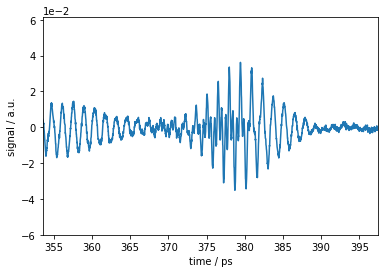

In [9]:
"""Choose one of the next lines: 
1. "inline" for normal/static plot
2. "notebook" for interactiv plot
"""
%matplotlib inline
#%matplotlib notebook

data_mean = tplot.get_data_mean(tplot.data)

fig, ax = plt.subplots()

for loop in range(int(tplot.data.shape[1]-1)):
    if tplot.data.shape[1] == 2:
        ax.plot(tplot.data[:,0], tplot.data[:,loop+1])
    else:
        ax.plot(tplot.data[:,0], tplot.data[:,loop+1], label="file "+str(tplot.filenames[loop][:3]))

if tplot.data.shape[1] > 2:
#    ax.plot(data_mean[:,0], data_mean[:,1], label="mean value of all loops")
    leg = ax.legend(loc='lower left', shadow=True)

xlim = np.array([np.min(tplot.data[:,0]), np.max(tplot.data[:,0])])
ax.set_xlim(xlim[0]+5, xlim[1]-5)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_xlabel(r'time / ps');
ax.set_ylabel(r'signal / a.u.');

### 2.4. FFT plots

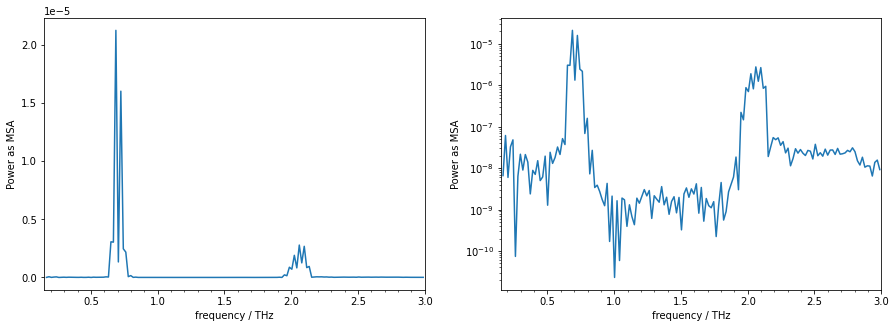

In [10]:
%matplotlib inline
fft_data_mean = tplot.get_data_mean(tplot.fft_data)

fig, axs = plt.subplots(ncols=2,figsize=(15, 5)) # set size of figure
n = (tplot.fft_data.shape[0]+1)*2  # +1 possible
mask = np.all([tplot.fft_data[:,0]>0.15, tplot.fft_data[:,0]<3], axis=0)

for loop in range(tplot.fft_data.shape[1]-1):
    if tplot.fft_data.shape[1] == 2:
        axs[0].plot(tplot.fft_data[mask,0], 2*(tplot.fft_data[mask,loop+1]/n)**2)
        axs[1].plot(tplot.fft_data[mask,0], 2*(tplot.fft_data[mask,loop+1]/n)**2)
    else:
        axs[0].plot(tplot.fft_data[mask,0], 2*(tplot.fft_data[mask,loop+1]/n)**2, label="file "+str(tplot.filenames[loop][:3]))
        axs[1].plot(tplot.fft_data[mask,0], 2*(tplot.fft_data[mask,loop+1]/n)**2, label="file "+str(tplot.filenames[loop][:3]))

if tplot.fft_data.shape[1] > 2:
#    axs[0].plot(fft_data_mean[mask,0], 2*(fft_data_mean[mask,1]/n)**2, label="mean value of all loops")
#    axs[1].plot(fft_data_mean[mask,0], 2*(fft_data_mean[mask,1]/n)**2, label="mean value of all loops")
    axs[0].legend(loc='upper right', shadow=True)
    axs[1].legend(loc='upper right', shadow=True)

a = np.arange(3)
ml = MultipleLocator(0.1)
axs[0].xaxis.set_minor_locator(ml)
axs[0].xaxis.set_tick_params(which='minor')
axs[0].set_xlabel(r'frequency / THz')
axs[0].set_ylabel(r'Power as MSA')
axs[0].set_xlim([0.15,3])
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axs[1].xaxis.set_minor_locator(ml)
axs[1].xaxis.set_tick_params(which='minor')
axs[1].set_xlabel(r'frequency / THz')
axs[1].set_ylabel(r'Power as MSA')
axs[1].set_xlim([0.15,3])
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
axs[1].set_yscale('log')
if tplot.fft_data.shape[1] >= 4:
    axs[1].legend(loc='lower left', shadow=True)